In [1]:
import os
import pandas as pd
import numpy as np
from shutil import rmtree, copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb

# Project variables

In [2]:
m_name = "distilbert_2_classes_v2"
p_dir = os.path.join("../nlp models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [6]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [7]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [8]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [9]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)

# Define categories

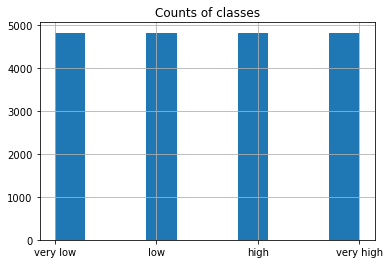

In [10]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [11]:
cat_lbl = ["very low", "very high"]
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

5793 1931 1932


# Build the model

In [12]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [13]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [15]:
x_train_pp = preprocess_data(x_train)
x_val_pp = preprocess_data(x_val)

In [16]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [17]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [18]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)
model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

2021-10-18 18:42:36.864946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 18:42:36.937030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 18:42:36.937693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-18 18:42:36.939541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     327600      tf_distil_bert_model[0][0]   

# Train the model

In [20]:
x_train_tok = tokenize(x_train_pp, tok)
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

batch_size = 64
n_epochs = 200

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.00005), 
              metrics=["accuracy"])

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_val_tok[:2], y_val_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

2021-10-18 18:42:48.822359: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-10-18 18:42:56.509875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


91/91 [==============================] - 36s 306ms/step - loss: 0.5797 - accuracy: 0.7064 - val_loss: 0.4524 - val_accuracy: 0.8193

Epoch 00001: val_loss improved from inf to 0.45238, saving model to ../nlp models/distilbert_2_classes_v2/distilbert_2_classes_v2
Epoch 2/200
91/91 [==============================] - 26s 288ms/step - loss: 0.4322 - accuracy: 0.8063 - val_loss: 0.3814 - val_accuracy: 0.8312

Epoch 00002: val_loss improved from 0.45238 to 0.38140, saving model to ../nlp models/distilbert_2_classes_v2/distilbert_2_classes_v2
Epoch 3/200
91/91 [==============================] - 26s 285ms/step - loss: 0.3947 - accuracy: 0.8220 - val_loss: 0.3568 - val_accuracy: 0.8421

Epoch 00003: val_loss improved from 0.38140 to 0.35683, saving model to ../nlp models/distilbert_2_classes_v2/distilbert_2_classes_v2
Epoch 4/200
91/91 [==============================] - 26s 287ms/step - loss: 0.3692 - accuracy: 0.8364 - val_loss: 0.3420 - val_accuracy: 0.8493

Epoch 00004: val_loss improved fro

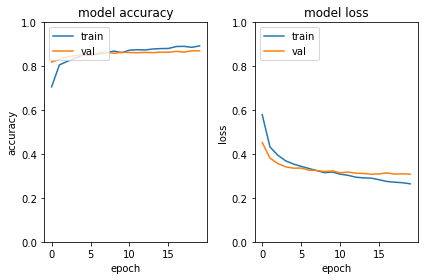

In [21]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [22]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Validation data (in-sample)

In [23]:
x_val_tok = tokenize(x_val_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_val_b = lb.transform(y_val)

y_val_prob = model.predict(x_val_tok[:2], steps=y_val_b.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

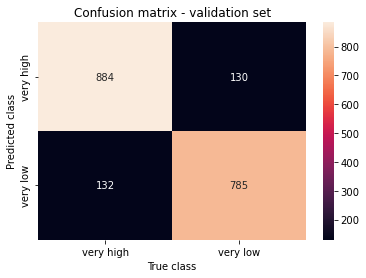

Accuracy: 0.86
Micro precision: 0.86
Micro recall: 0.86
Micro F1-score: 0.86
Macro precision: 0.86
Macro recall: 0.86
Macro F1-score: 0.86
Weighted precision: 0.86
Weighted recall: 0.86
Weighted F1-score: 0.86
              precision    recall  f1-score   support

    very low       0.87      0.87      0.87      1014
   very high       0.86      0.86      0.86       917

    accuracy                           0.86      1931
   macro avg       0.86      0.86      0.86      1931
weighted avg       0.86      0.86      0.86      1931



In [24]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

print(classification_report(y_val, y_pred, target_names=cat_lbl))

## Test data (out-of-sample)

In [25]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

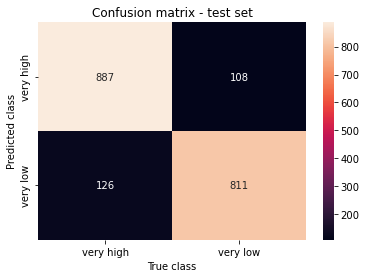

Accuracy: 0.88
Micro precision: 0.88
Micro recall: 0.88
Micro F1-score: 0.88
Macro precision: 0.88
Macro recall: 0.88
Macro F1-score: 0.88
Weighted precision: 0.88
Weighted recall: 0.88
Weighted F1-score: 0.88
              precision    recall  f1-score   support

    very low       0.88      0.89      0.88       995
   very high       0.88      0.87      0.87       937

    accuracy                           0.88      1932
   macro avg       0.88      0.88      0.88      1932
weighted avg       0.88      0.88      0.88      1932



In [26]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

# ROC curve

## Validation data (in-sample)

In [27]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_val_no = lb.fit_transform(y_val)
y_pred_no = y_val_prob[:, 1]
fpr, tpr, thr = roc_curve(y_val_no, y_pred_no)

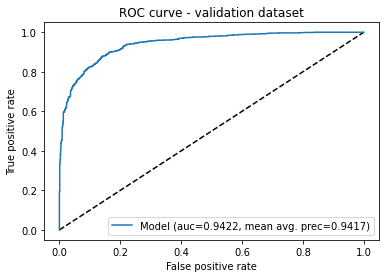

In [28]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_val_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - validation dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_val.jpg"))
plt.show()

## Test data (out-of-sample)

In [29]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

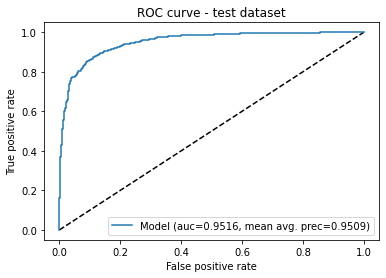

In [30]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

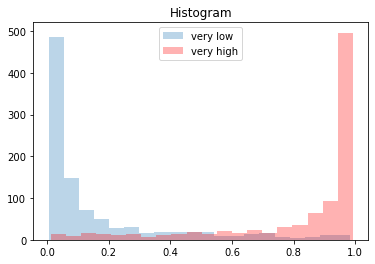

In [31]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

## Including middle classes

In [32]:
cat_lbl2 = ["very low", "low", "high", "very high"]
combo2 = combo.copy()
combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [33]:
combo2 = combo2.loc[combo2.qtl.isin(["low", "high"]), :]
combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2896 966 966


In [34]:
x_test_pp2 = preprocess_data(x_test2)
x_test_tok2 = tokenize(x_test_pp2, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b2 = lb.transform(y_test2)

y_pred_prob2 = model.predict(x_test_tok2[:2], steps=y_test_b2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
y_pred2 = lb.inverse_transform(y_pred2)

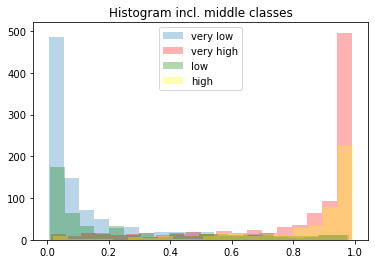

In [35]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

m3 = y_test2 == "low"
c2 = y_pred_prob2[m3, 0]

m4 = y_test2 == "high"
c3 = y_pred_prob2[m4, 0]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.hist(c3, color="yellow", alpha=0.3, label="", bins=20)
plt.title("Histogram incl. middle classes")
plt.legend(cat_lbl + ["low", "high"])
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

# Sample titles

## Validation dataset

In [36]:
x1 = x_test2[["title", "channel_name"]]
x2 = y_test2
x3 = pd.Series(y_pred2, name="pred")

x4 = x_test[["title", "channel_name"]]
x5 = y_test
x6 = pd.Series(y_pred, name="pred")

c1 = pd.concat([x1, x2], axis=1).reset_index(drop=True)
c1 = pd.concat([c1, x3], axis=1)

c2 = pd.concat([x4, x5], axis=1).reset_index(drop=True)
c2 = pd.concat([c2, x6], axis=1)

c3 = pd.concat([c1, c2])

print(c3.shape)
c3.head()

(2898, 4)


,title,channel_name,qtl,pred
0,Why Do You Love Your Family?,It's Okay To Be Smart,high,very high
1,Artificial Intelligence Tutorial | Artificial ...,Simplilearn,high,very low
2,The Force - Sixty Symbols,Sixty Symbols,high,very high
3,Bamboo Engineering,Massachusetts Institute of Technology (MIT),high,very high
4,HARP TWINS and more... -- BiDiPi #17,Vsauce2,high,very low


In [37]:
g = c3.loc[c3["qtl"].isin(["very high", "very low"]), :].groupby("pred", as_index=False).apply(lambda x: x.sample(5, random_state=256))
# g = g.loc[g["qtl"].isin(["very low"]), "title"]
g[["title", "pred"]].head(10)

title       pred
0 1522  Can You Boil Water Just By Mixing it Really Fa...  very high
  1222   The World's Best Mathematician (*) - Numberphile  very high
  1498              Lightbulbs, Multiplication, and More!  very high
  637                           Are You Paying Attention?  very high
  530           Why Does Hair Get Frizzy When It's Humid?  very high
1 86    Closures in JavaScript | Closures Tutorial | J...   very low
  1381                                How Weed Works: THC   very low
  1854  Explaining Thermodynamics - Monthly(ish) Mailb...   very low
  648   Apache Spark Machine Learning | Apache Spark T...   very low
  546                  How to fool a GPS - Todd Humphreys   very low

In [38]:
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)

# Save test set pre

In [39]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))